In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
import patoolib as pl
import glob
import os
import cv2

2025-06-29 21:56:14.803967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


OpenCV: Couldn't read video stream from file "/Users/hafiz/Downloads/Datascience_Memorize/UCF11_updated_mpg/basketball/v_shooting_24/v_shooting_24_01.mpg"


[0, 141, 141, 286, 286, 442, 442, 584, 584, 782, 782, 938, 938, 1075, 1075, 1242, 1242, 1361, 1361, 1477, 1477, 1600]


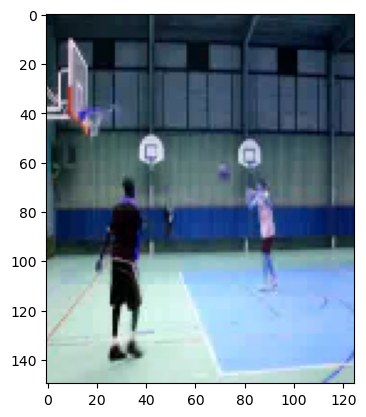

In [2]:
# URL = 'UCF11_updated_mpg.rar'
# extract_file = pl.extract_archive(URL)

action_categories = ['basketball','biking','diving','golf_swing','horse_riding','soccer_juggling','swing','tennis_swing','trampoline_jumping','volleyball_spiking','walking']
path = '/Users/hafiz/Downloads/Datascience_Memorize/UCF11_updated_mpg/basketball'
file_index = []
index_num = 0
Frames = [] #This is where the frames for each video is stored before normalizing
Frames_label = [] #This is where the labels are stored
label = 0
count = 0
num_F = 12 #This is the number of frames to use in the program at each step

for file in action_categories:
    path = '/Users/hafiz/Downloads/Datascience_Memorize/UCF11_updated_mpg/' + file
    file_index.append(index_num)
    for item in list(glob.glob(path + '/**/*.mpg', recursive=True)):
        #Program that processes and prepares each video file before we feed them into the model
        
        temp = []
        i = 0
        ret = False
        video = cv2.VideoCapture(item)
        ret, frame = video.read()
        while ret == True and i < num_F:
            if(ret == True):
                re_sized = cv2.resize(frame, (125,150), fx=0.1, fy=0.1)
                temp.append(re_sized)
                if count == 0:
                    plt.imshow(re_sized)
                    count = count + 1
            else:
                break
            ret, frame = video.read()
            i = i + 1
            #End of while loop
        
        video.release()
        
        if len(temp)>0:
            Frames.append(temp)
            Frames_label.append(label)

        index_num = index_num + 1
    label = label + 1
    file_index.append(index_num)
print(file_index)
Frames_label = np.array(Frames_label)


In [3]:
same_len = True
id_x = []
t_count = 0
for t in range(len(Frames)):
    if len(Frames[t]) > num_F or len(Frames[t]) < num_F:
        temp_len = num_F - len(Frames[t])
        for d in range(temp_len):
            arr = np.zeros((150, 125, 3))#
            Frames[t].append(arr)
        same_len = False
        id_x.append(t)
    t_count = t_count + 1
print(f"The length is {same_len} and the index is {id_x}")
print(f"{len(Frames)} and the count is {count} ")

print(Frames[127][7].shape)
print(Frames[36][7].shape)
print(Frames[40][7].shape)


The length is False and the index is [36, 127]
1599 and the count is 1 
(150, 125, 3)
(150, 125, 3)
(150, 125, 3)


In [4]:
#Check to make sure the data in the list is of the same shape and then Normalize the data
wrong_frame = [] #This array holds data items that are of the wrong shape
correct_shape = (150, 125, 3) #This is the shape every data item should have
out_count = 0
in_count = 0
for vid in Frames:
    for img in vid:
        tmp_shp = img.shape
        if tmp_shp != correct_shape:
            wrong_index = (out_count, in_count)
            wrong_frame.append(wrong_index)
        in_count = in_count + 1
    out_count = out_count + 1

###########
#If the data has the wrong frame code to adjust it can be added here
###########

norm_data = [] #This is the array that contains my normalized data
wrong_d = []
for vid in Frames:
    tmp_norm = [] #List of Frames for each video
    for img in vid:
        tmp_hold = img/255.0
        tmp_hold = tf.convert_to_tensor(tmp_hold, dtype=tf.float32) #This line changes each entry into a tensor
        if len(img) < num_F:
            wrong_d.append(img)
        tmp_norm.append(tmp_hold)
    tmp_norm = np.stack(tmp_norm, axis=0) #added
    norm_data.append(tmp_norm)


norm_data = np.stack(norm_data, axis=0) #added

print(norm_data.shape)
print(norm_data.dtype)
print(Frames_label.shape)
print(Frames_label.dtype)

(1599, 12, 150, 125, 3)
float32
(1599,)
int64


In [5]:
#Split data into train, test sets
from sklearn.model_selection import train_test_split

X_train, X_test, train_label, test_label = train_test_split(norm_data, Frames_label, test_size=0.2, stratify=Frames_label, random_state=42)

print(X_train.shape)
print(X_train.dtype)
print(X_test.shape)
print(X_test.dtype)
print(train_label.shape)
print(train_label.dtype)
print(test_label.shape)
print(test_label.dtype)

(1279, 12, 150, 125, 3)
float32
(320, 12, 150, 125, 3)
float32
(1279,)
int64
(320,)
int64


In [6]:
#Neural Network for training model used for video analysis
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_F, 150, 125, 3)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling3D(pool_size=3),
    tf.keras.layers.Conv3D(filters=32, kernel_size=5, strides=1, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv3D(filters=32, kernel_size=5, strides=1, padding='same',activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=3),
    tf.keras.layers.Conv3D(filters=32, kernel_size=5, strides=1, padding='same',activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])


In [7]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 12, 150, 125,   │        12,032 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 150, 125,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 4, 50, 41, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 4, 50, 41, 32)  │       128,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 50, 41, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 50, 41, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 50, 41, 32)  │       128,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 1, 16, 13, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 1, 16, 13, 32)  │       128,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       426,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,147 (3.14 MB)

 Trainable params: 823,019 (3.14 MB)

 Non-trainable params: 128 (512.00 B)

In [8]:
model.fit(X_train, train_label, epochs=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4321s 106s/step - accuracy: 0.1348 - loss: 2.6828


In [44]:
loss, acc = model.evaluate(X_test, test_label)
print(f"The evaluation accuracy {acc:.4f} and loss {loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 119s 12s/step - accuracy: 0.1186 - loss: 3.0139
The evaluation accuracy 0.1281 and loss 2.9993


In [36]:
#Following compilation and fitting, i want to predict which category a video belongs
single_video_path = '/Users/hafiz/Downloads/Datascience_Memorize/UCF11_updated_mpg/horse_riding/v_riding_01/v_riding_01_05.mpg'
single_video = glob.glob(single_video_path)
predict_frame = []
frame_count = 0
predict_video = cv2.VideoCapture(single_video[0])
ret, frame = predict_video.read()

while ret and frame_count < num_F:
    new_frame = cv2.resize(frame, (125,150), fx=0.1, fy=0.1)
    new_frame = new_frame/255.0
    predict_frame.append(new_frame)
    frame_count = frame_count + 1
    ret, frame = predict_video.read()

expanded_predict_frame = np.expand_dims(predict_frame, axis=0)
result = model.predict(expanded_predict_frame)
predicted_class = np.argmax(result)

print(result)
print(f"The predicted category of that video is {action_categories[predicted_class]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
[[0.00312826 0.04712999 0.07006922 0.00898848 0.48050487 0.16841196
  0.10475122 0.00582121 0.01307986 0.00211183 0.09600311]]
The predicted category of that video is horse_riding
